##**Lookalike Modelling**

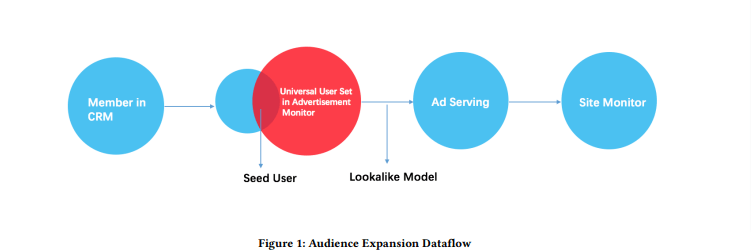

##**DATA PREPARATION**

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load data
customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Products.csv")
products = pd.read_csv("/content/Transactions.csv")

In [ ]:
customers.head(2)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13


In [ ]:
products.head(2)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68


In [ ]:
transactions.head(2)

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.3
1,P002,ActiveWear Smartwatch,Electronics,346.3


In [ ]:
customers.shape, products.shape, transactions.shape

((200, 4), (1000, 7), (100, 4))

##**Data Transformation**

In [ ]:
# Merge transactions with products to include product details
transactions_products = transactions.merge(products, on='ProductID', how='left')
transactions_products.shape
transactions_products.isna().sum()
transactions_products.duplicated().sum()
transactions_products.head()
transactions_products.shape

(1000, 10)

In [ ]:
# Merge the transactions_products with customers to include customer details
data = transactions_products.merge(customers, on='CustomerID', how='left')
data.shape
data.isna().sum()
data.duplicated().sum()
data.shape


(1000, 13)

In [ ]:
data.head()

,ProductID,ProductName,Category,Price_x,TransactionID,CustomerID,TransactionDate,Quantity,TotalValue,Price_y,CustomerName,Region,SignupDate
0,P001,ActiveWear Biography,Books,169.3,T00088,C0019,2024-01-30 17:23:03,2,338.6,169.3,Brandon Rodriguez,Europe,2023-01-12
1,P001,ActiveWear Biography,Books,169.3,T00314,C0024,2024-09-24 17:15:16,4,677.2,169.3,Michele Cooley,North America,2024-02-05
2,P001,ActiveWear Biography,Books,169.3,T00428,C0071,2024-08-02 08:13:23,2,338.6,169.3,Taylor Murphy,South America,2022-07-01
3,P001,ActiveWear Biography,Books,169.3,T00433,C0036,2024-05-05 05:01:18,2,338.6,169.3,Brian Aguilar DDS,North America,2024-07-06
4,P001,ActiveWear Biography,Books,169.3,T00449,C0191,2024-12-12 12:17:38,1,169.3,169.3,Samantha Gibson DVM,South America,2024-04-07


In [ ]:
(data['Price_x'] == data['Price_y']).value_counts()
#we should drop one of the columns
data.drop('Price_y', axis=1, inplace=True)

In [ ]:
data.head(1)

,ProductID,ProductName,Category,Price_x,TransactionID,CustomerID,TransactionDate,Quantity,TotalValue,CustomerName,Region,SignupDate
0,P001,ActiveWear Biography,Books,169.3,T00088,C0019,2024-01-30 17:23:03,2,338.6,Brandon Rodriguez,Europe,2023-01-12


In [ ]:
# Aggregating data to create customer profiles
# Summarize purchase behavior by CustomerID
customer_profiles = data.groupby('CustomerID').agg({
    'ProductName': lambda x: list(x),  # List of products purchased
    'Category': lambda x: list(x),  # List of product categories
    'TotalValue': 'sum',  # Total value of purchases
    'Quantity': 'sum',  # Total quantity purchased
    'Region': 'first',  # Customer region
    'SignupDate': 'first'  # Signup date
}).reset_index()

# Preview customer profiles
customer_profiles.head()


,CustomerID,ProductName,Category,TotalValue,Quantity,Region,SignupDate
0,C0001,"[HomeSense Wall Art, TechPro Headphones, Sound...","[Home Decor, Electronics, Books, Electronics, ...",3354.52,12,South America,2022-07-10
1,C0002,"[BookWorld Rug, ComfortLiving Sweater, TechPro...","[Home Decor, Clothing, Clothing, Home Decor]",1862.74,10,Asia,2022-02-13
2,C0003,"[ActiveWear Smartwatch, ActiveWear Rug, Active...","[Electronics, Home Decor, Home Decor, Clothing]",2725.38,14,South America,2024-03-07
3,C0004,"[BookWorld Bluetooth Speaker, SoundWave Cookbo...","[Electronics, Books, Home Decor, Home Decor, B...",5354.88,23,South America,2022-10-09
4,C0005,"[ComfortLiving Headphones, ActiveWear Cookware...","[Electronics, Home Decor, Electronics]",2034.24,7,Asia,2022-08-15


##**Data preprocessing**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Encode categorical data (ProductName and Category) into a textual format for vectorization
customer_profiles['ProductData'] = customer_profiles['ProductName'].apply(lambda x: ' '.join(x)) + ' ' + \
                                   customer_profiles['Category'].apply(lambda x: ' '.join(x))
customer_profiles['ProductData'][0]

'HomeSense Wall Art TechPro Headphones SoundWave Cookbook ActiveWear Smartwatch SoundWave Headphones Home Decor Electronics Books Electronics Electronics'

In [ ]:
customer_profiles.head(1)

,CustomerID,ProductName,Category,TotalValue,Quantity,Region,SignupDate,ProductData
0,C0001,"[HomeSense Wall Art, TechPro Headphones, Sound...","[Home Decor, Electronics, Books, Electronics, ...",3354.52,12,South America,2022-07-10,HomeSense Wall Art TechPro Headphones SoundWav...


In [ ]:
customer_profiles.shape

(199, 8)

In [ ]:
# Vectorize the product and category data
vectorizer = CountVectorizer()
product_vectors = vectorizer.fit_transform(customer_profiles['ProductData'])
product_vectors.shape
product_vectors

<199x37 sparse matrix of type '<class 'numpy.int64'>'
	with 2482 stored elements in Compressed Sparse Row format>

In [ ]:
# Normalize numerical data (TotalValue and Quantity)
scaler = MinMaxScaler()
numerical_data = scaler.fit_transform(customer_profiles[['TotalValue', 'Quantity']])
numerical_data

array([[0.30894178, 0.35483871],
       [0.16809501, 0.29032258],
       [0.24954138, 0.41935484],
       [0.49780626, 0.70967742],
       [0.18428723, 0.19354839],
       [0.39137101, 0.35483871],
       [0.2357983 , 0.22580645],
       [0.39552906, 0.61290323],
       [0.07686723, 0.06451613],
       [0.15438686, 0.35483871],
       [0.34439282, 0.38709677],
       [0.48613465, 0.58064516],
       [0.5587683 , 0.5483871 ],
       [0.02231032, 0.03225806],
       [0.10150772, 0.09677419],
       [0.35802827, 0.29032258],
       [0.44105704, 0.64516129],
       [0.44370349, 0.5483871 ],
       [0.19859869, 0.32258065],
       [0.07931353, 0.06451613],
       [0.50394703, 0.51612903],
       [0.43173353, 0.4516129 ],
       [0.47927916, 0.41935484],
       [0.33466994, 0.41935484],
       [0.14232626, 0.22580645],
       [0.32730838, 0.35483871],
       [0.23420457, 0.35483871],
       [0.63609533, 0.74193548],
       [0.16083731, 0.29032258],
       [0.23295262, 0.38709677],
       [0.

In [ ]:
# Combine numerical data and product vectors for similarity computation
combined_features = np.hstack((product_vectors.toarray(), numerical_data))
combined_features

array([[1.        , 1.        , 0.        , ..., 1.        , 0.30894178,
        0.35483871],
       [0.        , 0.        , 0.        , ..., 0.        , 0.16809501,
        0.29032258],
       [4.        , 0.        , 0.        , ..., 0.        , 0.24954138,
        0.41935484],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.08020292,
        0.06451613],
       [1.        , 1.        , 0.        , ..., 1.        , 0.17909816,
        0.25806452],
       [1.        , 0.        , 0.        , ..., 0.        , 0.44150834,
        0.48387097]])

In [ ]:
# Compute cosine similarity
similarity_matrix = cosine_similarity(combined_features)
similarity_matrix

array([[1.        , 0.20551601, 0.41925992, ..., 0.29300355, 0.52087374,
        0.4588758 ],
       [0.20551601, 1.        , 0.52712084, ..., 0.23820907, 0.48369088,
        0.41329546],
       [0.41925992, 0.52712084, 1.        , ..., 0.13832878, 0.52081035,
        0.42853235],
       ...,
       [0.29300355, 0.23820907, 0.13832878, ..., 1.        , 0.29245753,
        0.59261647],
       [0.52087374, 0.48369088, 0.52081035, ..., 0.29245753, 1.        ,
        0.38128802],
       [0.4588758 , 0.41329546, 0.42853235, ..., 0.59261647, 0.38128802,
        1.        ]])

In [ ]:
# Map similarity scores for the first 20 customers (C0001 to C0020)
top_20_customers = customer_profiles[customer_profiles['CustomerID'].str.startswith('C00')].iloc[:20]
lookalike_results = {}

for i, customer_id in enumerate(top_20_customers['CustomerID']):
    # Get similarity scores for the current customer
    customer_idx = customer_profiles[customer_profiles['CustomerID'] == customer_id].index[0]
    scores = similarity_matrix[customer_idx]

    # Get top 3 most similar customers (excluding the customer itself)
    similar_indices = scores.argsort()[::-1][1:4]
    similar_customers = [
        (customer_profiles.iloc[idx]['CustomerID'], scores[idx]) for idx in similar_indices
    ]

    # Store results
    lookalike_results[customer_id] = similar_customers

In [ ]:
# Convert results to a DataFrame
lookalike_df = pd.DataFrame([
    {'cust_id': cust_id, 'lookalikes': str(lookalikes)}
    for cust_id, lookalikes in lookalike_results.items()
])

In [ ]:
# Save to Lookalike.csv
output_path = 'Lookalike.csv'
lookalike_df.to_csv(output_path, index=False)
output_path

'Lookalike.csv'